In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import sys

from normalizingflows.flow_catalog import PlanarFlow
from data.visu_density import plot_heatmap_2d
from data.toy_data import generate_2d_data
from data.plot_samples import plot_samples_2d
from utils.train_utils import shuffle_split, sanity_check, train_density_estimation

tfd = tfp.distributions
tfb = tfp.bijectors
tf.random.set_seed(1234)

#tf.config.run_functions_eagerly(True) #note runs slow, gets rid of tf.Variable error trying to run training after previous train

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


# TUMS Dataset

## 2000 training, 8 layers

In [2]:
# parameters
dataset_size = 2000
batch_size = 800
dataset = 'tum'
layers = 8
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

2022-02-16 19:17:22.376087: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 19:17:22.377120: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


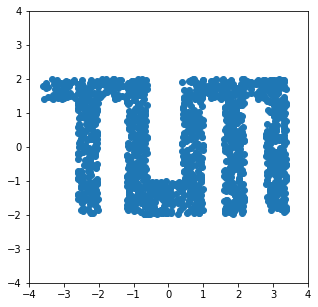

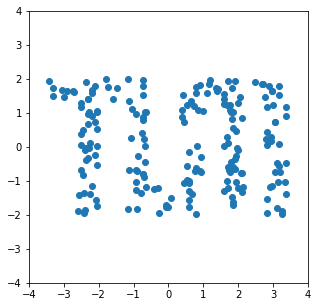

In [3]:
train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

In [4]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

In [5]:
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

In [6]:
# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print(len(x_dist.trainable_variables))

24


In [7]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [8]:
checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

0, train_loss: 5.92497444152832, val_loss: 5.856307506561279
100, train_loss: 3.7646384239196777, val_loss: 3.7723569869995117
200, train_loss: 3.54463529586792, val_loss: 3.5028421878814697
300, train_loss: 3.503424644470215, val_loss: 3.4305059909820557
400, train_loss: 3.4891204833984375, val_loss: 3.401324510574341
500, train_loss: 3.479348659515381, val_loss: 3.3874335289001465
600, train_loss: 3.469771385192871, val_loss: 3.380481004714966
700, train_loss: 3.4593591690063477, val_loss: 3.3771674633026123
800, train_loss: 3.449030876159668, val_loss: 3.373349666595459
900, train_loss: 3.439427375793457, val_loss: 3.365633487701416
1000, train_loss: 3.430657386779785, val_loss: 3.3543012142181396
1100, train_loss: 3.4230315685272217, val_loss: 3.3416554927825928
1200, train_loss: 3.41670560836792, val_loss: 3.329909324645996
1300, train_loss: 3.4113595485687256, val_loss: 3.320399761199951
1400, train_loss: 3.406531572341919, val_loss: 3.3135955333709717
1500, train_loss: 3.4018857

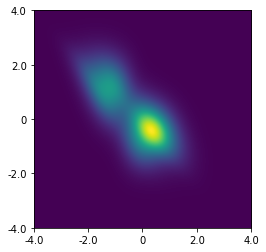

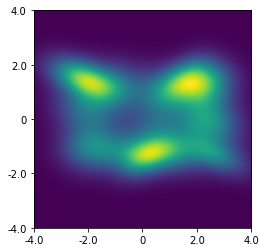

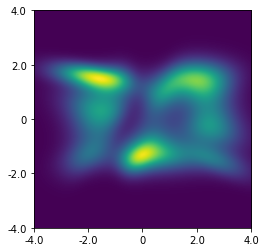

In [9]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

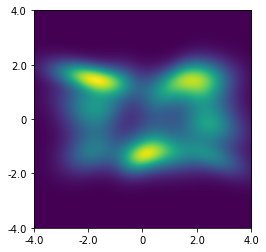

In [10]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

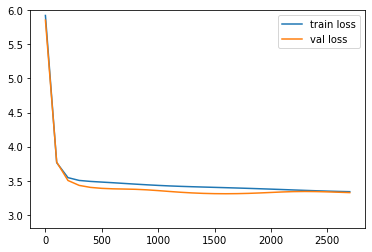

In [11]:
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

In [12]:
# Sanity check: ensure that the integral of the pdf sums up to 1
# create 2D mesh grid with N samples
integral = sanity_check(x_dist, xmin=-6.0, xmax=6.0, ymin=-6.0, ymax=6.0, mesh_count=2000)
print(integral)

tf.Tensor(0.9989931, shape=(), dtype=float32)


## 2000 training, 16 layers

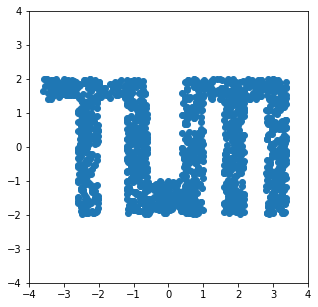

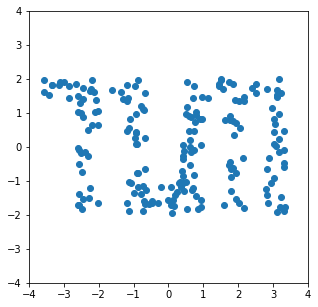

In [4]:
dataset_size = 2000
batch_size = 800
dataset = 'tum'
layers = 16
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

trainable params: 48
0, train_loss: 7.557399272918701, val_loss: 7.399925708770752
100, train_loss: 3.928834915161133, val_loss: 4.221174716949463
200, train_loss: 3.569045066833496, val_loss: 3.9017081260681152
300, train_loss: 3.4832603931427, val_loss: 3.790647029876709
400, train_loss: 3.440775156021118, val_loss: 3.7268640995025635
500, train_loss: 3.4110231399536133, val_loss: 3.6881656646728516
600, train_loss: 3.3860175609588623, val_loss: 3.65673828125
700, train_loss: 3.3644354343414307, val_loss: 3.629318952560425
800, train_loss: 3.346545457839966, val_loss: 3.6074535846710205
900, train_loss: 3.3324573040008545, val_loss: 3.5896642208099365
1000, train_loss: 3.3197624683380127, val_loss: 3.5711989402770996
1100, train_loss: 3.3089683055877686, val_loss: 3.5546884536743164
1200, train_loss: 3.3011724948883057, val_loss: 3.543052911758423
1300, train_loss: 3.2947843074798584, val_loss: 3.5342462062835693
1400, train_loss: 3.28751277923584, val_loss: 3.524008274078369
1500, t

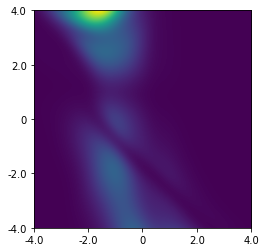

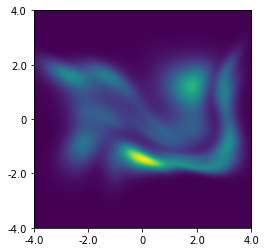

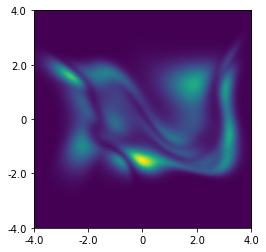

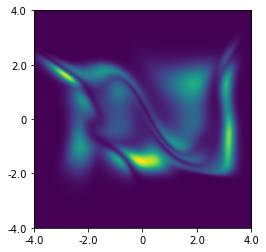

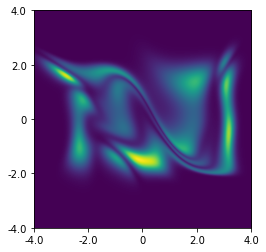

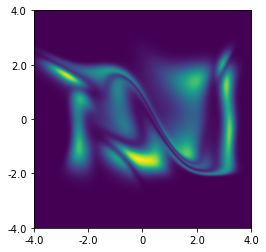

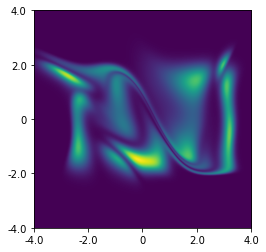

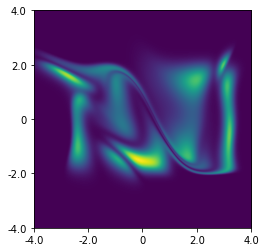

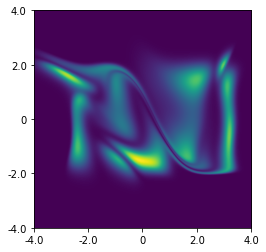

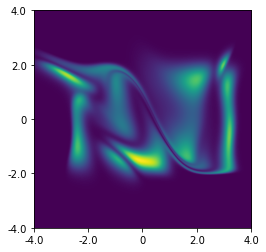

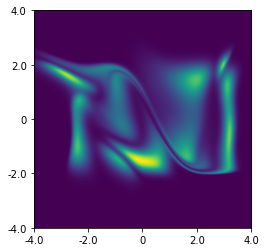

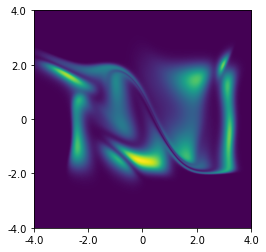

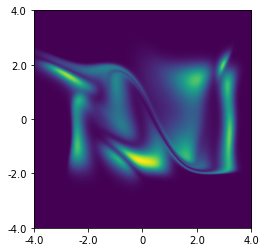

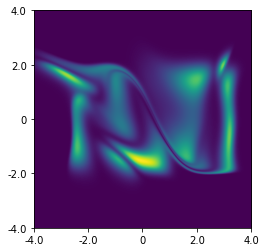

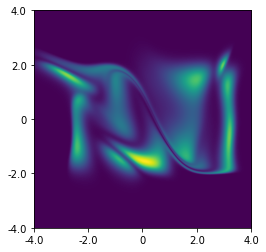

In [6]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print('trainable params: ' + str(len(x_dist.trainable_variables)))

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Optimization parameters
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

# Training
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

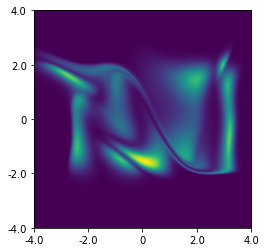

In [8]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
'''t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start'''

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)


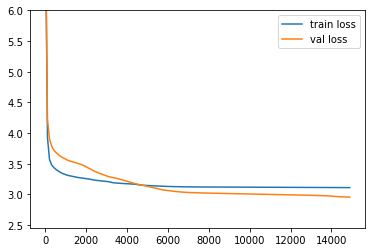

In [9]:
# validation plot
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

## 100 training, 16 layers

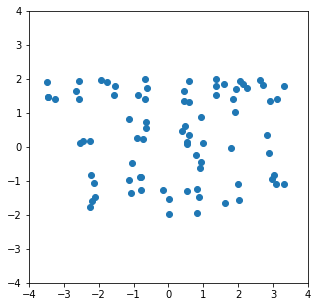

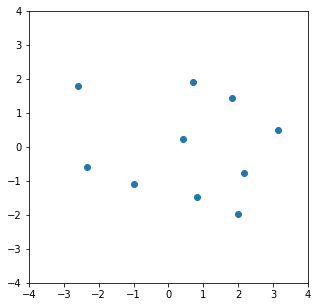

In [3]:
dataset_size = 100
batch_size = 100
dataset = 'tum'
layers = 16
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

trainable params: 48
0, train_loss: 11.320818901062012, val_loss: 11.681326866149902
100, train_loss: 5.156659126281738, val_loss: 5.653880596160889
200, train_loss: 3.852407932281494, val_loss: 4.117156505584717
300, train_loss: 3.5976059436798096, val_loss: 3.7915561199188232
400, train_loss: 3.502650499343872, val_loss: 3.679447650909424
500, train_loss: 3.4375128746032715, val_loss: 3.611337184906006
600, train_loss: 3.388063430786133, val_loss: 3.5653138160705566
700, train_loss: 3.351022243499756, val_loss: 3.5326390266418457
800, train_loss: 3.3238842487335205, val_loss: 3.5082621574401855
900, train_loss: 3.3051018714904785, val_loss: 3.494424819946289
1000, train_loss: 3.2924094200134277, val_loss: 3.4914746284484863
1100, train_loss: 3.2835090160369873, val_loss: 3.496859312057495
1200, train_loss: 3.27677845954895, val_loss: 3.508495330810547
1300, train_loss: 3.27109956741333, val_loss: 3.526048183441162
1400, train_loss: 3.2654411792755127, val_loss: 3.545555830001831
1500

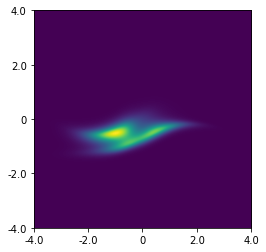

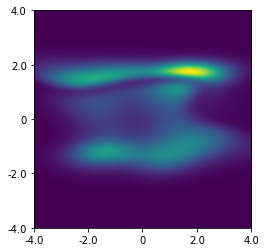

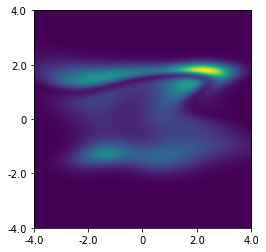

In [4]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print('trainable params: ' + str(len(x_dist.trainable_variables)))

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Optimization parameters
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

# Training
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

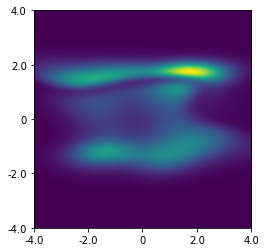

In [5]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
'''t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start'''

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

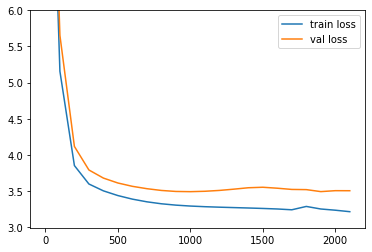

In [6]:
# validation plot
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

# CHECKERBOARD Datase

## 2000 training, 8 layers

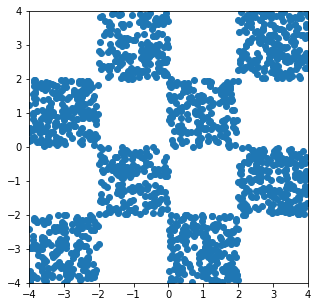

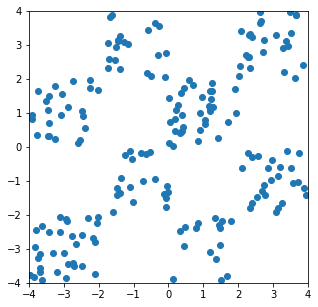

In [2]:
dataset_size = 2000
batch_size = 800
dataset = 'checkerboard'
layers = 8
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

trainable params: 24
0, train_loss: 9.541061401367188, val_loss: 9.188043594360352
100, train_loss: 5.199532985687256, val_loss: 4.965418815612793
200, train_loss: 4.265380382537842, val_loss: 4.1460161209106445
300, train_loss: 4.118385314941406, val_loss: 4.025505065917969
400, train_loss: 4.0753374099731445, val_loss: 3.988369941711426
500, train_loss: 4.051692962646484, val_loss: 3.9727044105529785
600, train_loss: 4.033422946929932, val_loss: 3.9677131175994873
700, train_loss: 4.015121936798096, val_loss: 3.9660842418670654
800, train_loss: 3.9936773777008057, val_loss: 3.9599618911743164
900, train_loss: 3.9673266410827637, val_loss: 3.950446844100952
1000, train_loss: 3.9478249549865723, val_loss: 3.9482998847961426
1100, train_loss: 3.937877893447876, val_loss: 3.9459381103515625
1200, train_loss: 3.9309802055358887, val_loss: 3.9425241947174072
1300, train_loss: 3.9254651069641113, val_loss: 3.938678026199341
1400, train_loss: 3.920731544494629, val_loss: 3.9346020221710205
1

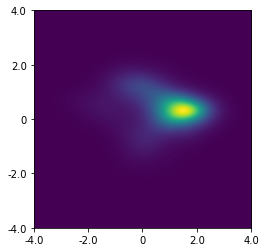

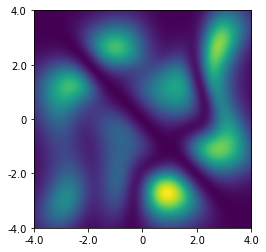

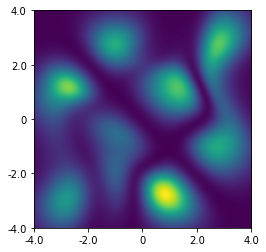

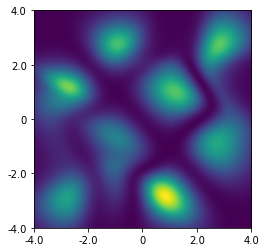

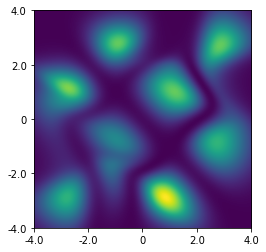

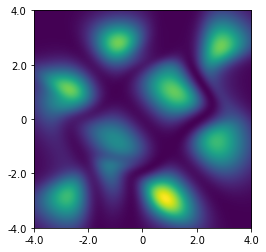

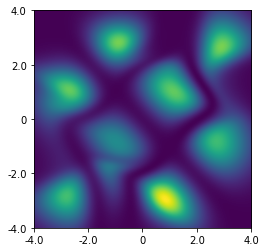

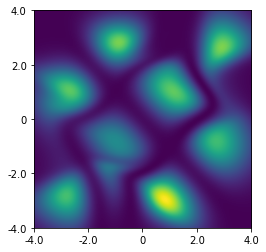

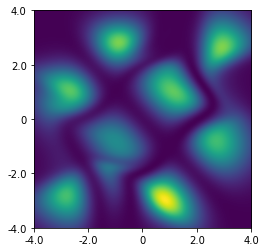

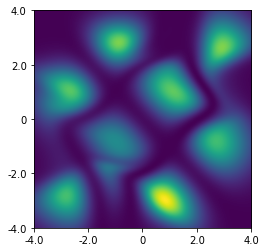

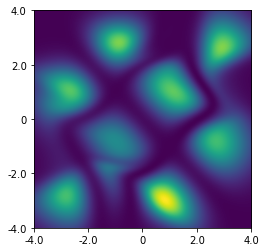

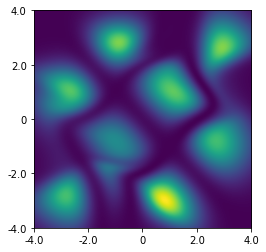

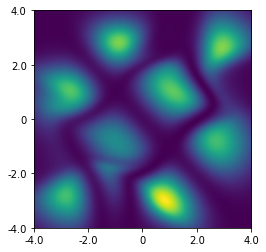

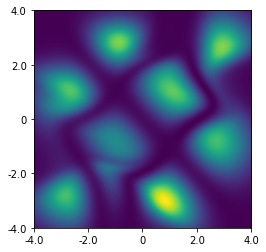

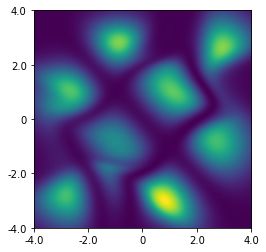

In [4]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print('trainable params: ' + str(len(x_dist.trainable_variables)))

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Optimization parameters
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

# Training
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

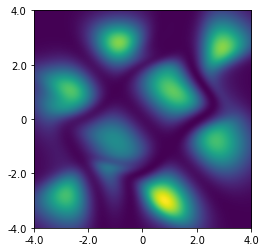

In [5]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
'''t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start'''

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

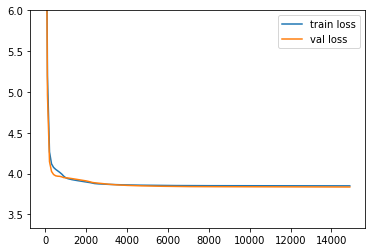

In [6]:
# validation plot
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

## 2000 training, 16 layers

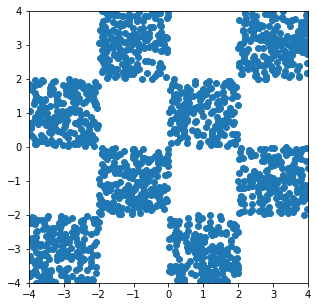

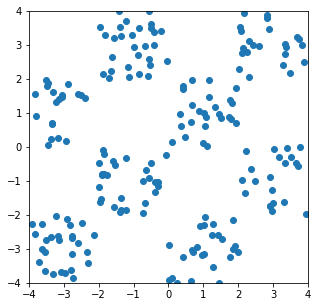

In [2]:
dataset_size = 2000
batch_size = 2000
dataset = 'checkerboard'
layers = 16
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(10e3)

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

trainable params: 48
0, train_loss: 9.183917045593262, val_loss: 8.863738059997559
100, train_loss: 5.616163730621338, val_loss: 5.514912128448486
200, train_loss: 4.592034816741943, val_loss: 4.542688846588135
300, train_loss: 4.290940761566162, val_loss: 4.2466912269592285
400, train_loss: 4.183466911315918, val_loss: 4.1315531730651855
500, train_loss: 4.144738674163818, val_loss: 4.087708950042725
600, train_loss: 4.127742767333984, val_loss: 4.0699262619018555
700, train_loss: 4.116348743438721, val_loss: 4.05998420715332
800, train_loss: 4.106718063354492, val_loss: 4.053115367889404
900, train_loss: 4.0976738929748535, val_loss: 4.047749042510986
1000, train_loss: 4.088737964630127, val_loss: 4.04316520690918
1100, train_loss: 4.079676151275635, val_loss: 4.03892707824707
1200, train_loss: 4.070322513580322, val_loss: 4.034669399261475
1300, train_loss: 4.060513496398926, val_loss: 4.030012130737305
1400, train_loss: 4.050070285797119, val_loss: 4.024551868438721
1500, train_los

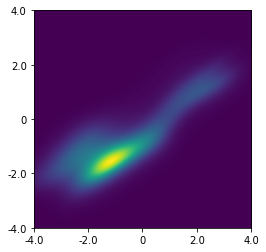

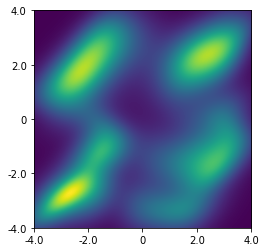

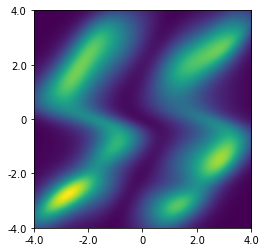

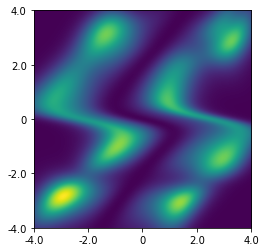

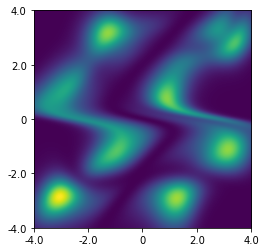

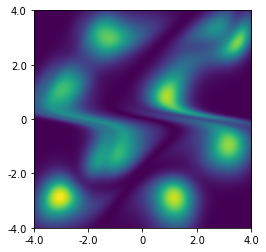

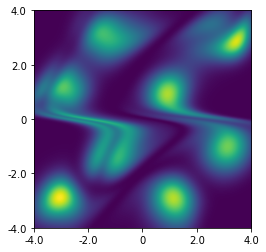

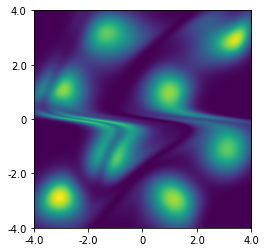

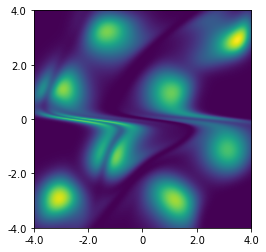

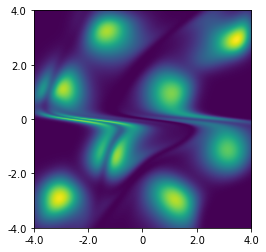

In [3]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print('trainable params: ' + str(len(x_dist.trainable_variables)))

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Optimization parameters
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

# Training
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        #elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            #break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

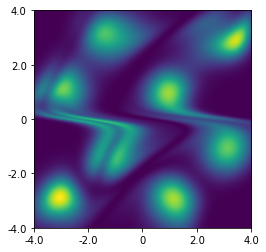

In [4]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
'''t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start'''

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

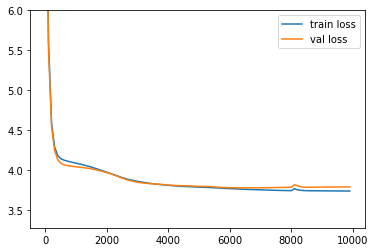

In [5]:
# validation plot
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

## 1000 training, 8 layers

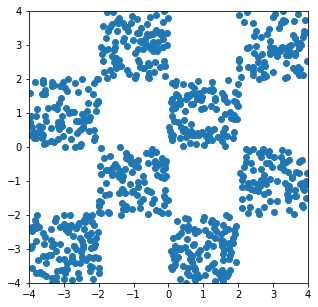

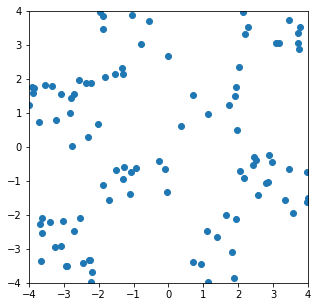

In [2]:
dataset_size = 1000
batch_size = 500
dataset = 'checkerboard'
layers = 8
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

trainable params: 24
0, train_loss: 9.311392784118652, val_loss: 9.856586456298828
100, train_loss: 5.325748920440674, val_loss: 5.411276817321777
200, train_loss: 4.449984073638916, val_loss: 4.408726215362549
300, train_loss: 4.261358737945557, val_loss: 4.208505630493164
400, train_loss: 4.204238414764404, val_loss: 4.165563583374023
500, train_loss: 4.170803070068359, val_loss: 4.144548416137695
600, train_loss: 4.142680644989014, val_loss: 4.127742767333984
700, train_loss: 4.112311840057373, val_loss: 4.11245059967041
800, train_loss: 4.077396869659424, val_loss: 4.098597049713135
900, train_loss: 4.042407035827637, val_loss: 4.08619499206543
1000, train_loss: 4.015768051147461, val_loss: 4.07856559753418
1100, train_loss: 4.001202583312988, val_loss: 4.078853130340576
1200, train_loss: 3.991946220397949, val_loss: 4.074163436889648
1300, train_loss: 3.984466552734375, val_loss: 4.0709147453308105
1400, train_loss: 3.9793038368225098, val_loss: 4.070124626159668
1500, train_loss:

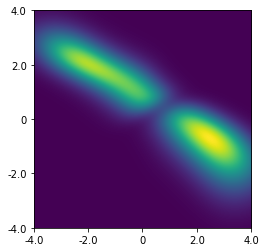

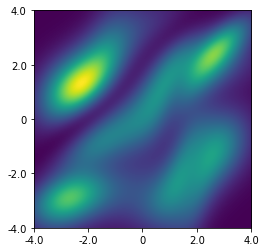

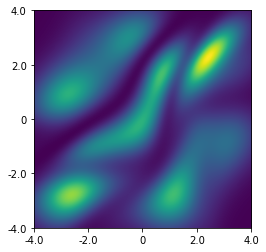

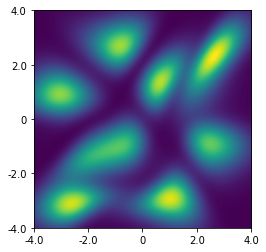

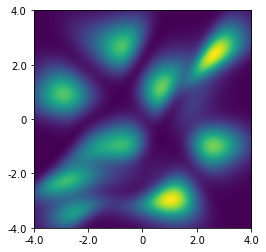

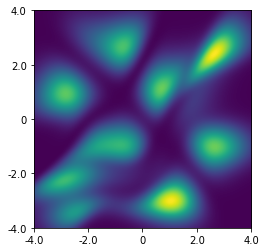

In [3]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print('trainable params: ' + str(len(x_dist.trainable_variables)))

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Optimization parameters
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

# Training
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

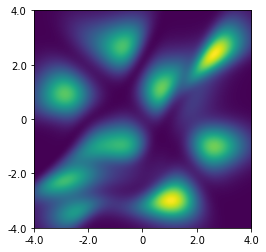

In [4]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
'''t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start'''

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

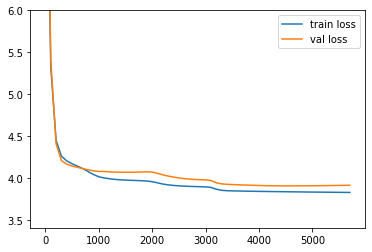

In [5]:
# validation plot
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

## 100 training, 8 layers

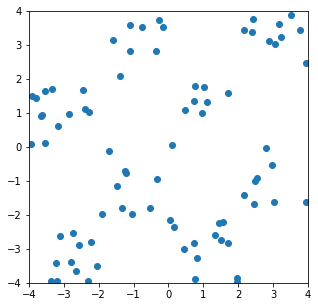

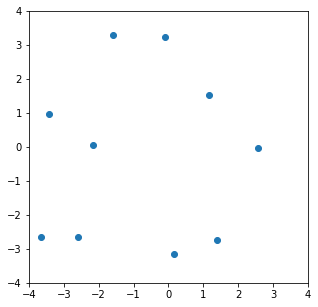

In [2]:
dataset_size = 100
batch_size = 100
dataset = 'checkerboard'
layers = 8
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)
plot_samples_2d(train_data)
plot_samples_2d(val_data)

train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

trainable params: 24
0, train_loss: 8.451034545898438, val_loss: 6.931890964508057
100, train_loss: 6.024553298950195, val_loss: 5.045155048370361
200, train_loss: 5.01950740814209, val_loss: 4.518549919128418
300, train_loss: 4.613755702972412, val_loss: 4.4040117263793945
400, train_loss: 4.432440757751465, val_loss: 4.361603736877441
500, train_loss: 4.340799331665039, val_loss: 4.334565162658691
600, train_loss: 4.2758307456970215, val_loss: 4.277251720428467
700, train_loss: 4.210574150085449, val_loss: 4.165118217468262
800, train_loss: 4.146309852600098, val_loss: 4.0549516677856445
900, train_loss: 4.090523719787598, val_loss: 4.0018134117126465
1000, train_loss: 4.043483734130859, val_loss: 3.975722551345825
1100, train_loss: 4.001748085021973, val_loss: 3.9531359672546387
1200, train_loss: 3.962217330932617, val_loss: 3.9326939582824707
1300, train_loss: 3.9841129779815674, val_loss: 4.038884162902832
1400, train_loss: 3.9249043464660645, val_loss: 3.987586259841919
1500, tra

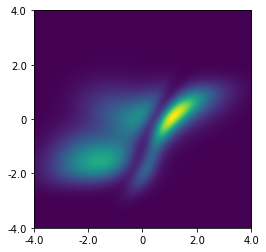

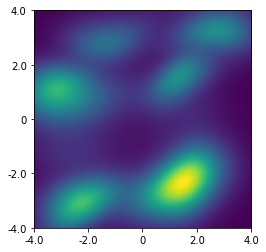

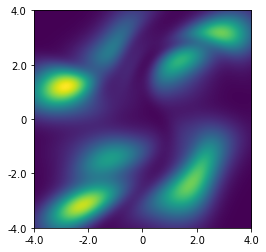

In [3]:
# assign a normal distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=2, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

x_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

# ensure invertibility
for bijector in x_dist.bijector.bijectors:
    bijector._u()
print('trainable params: ' + str(len(x_dist.trainable_variables)))

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

# Optimization parameters
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

checkpoint_directory = dataset + "/tmp_" + str(layers)
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=x_dist)

# Training
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(x_dist, opt, batch)

    # ensure that w.T * u > -1 (invertibility)
    for bijector in x_dist.bijector.bijectors:
        bijector._u()

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(x_dist.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap
        plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0)

train_time = time.time() - t_start

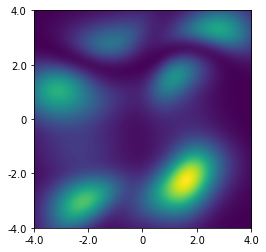

In [4]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
'''t_start = time.time()
test_loss = -tf.reduce_mean(x_dist.log_prob(test_data))
test_time = time.time() - t_start'''

# save density estimation of best model
save_dir = dataset + "/" + dataset + "_density_" + str(batch_size) + "_" + str(layers) + "_" + str(base_lr) + "_" + str(min_val_epoch)
plot_heatmap_2d(x_dist, -4.0, 4.0, -4.0, 4.0, name=save_dir)

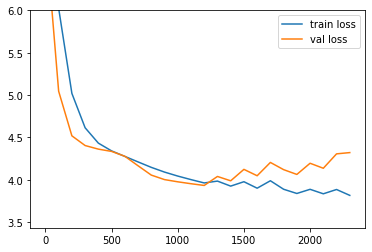

In [5]:
# validation plot
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()